# CardioSense — Component 3
## Personalized Cardiovascular Health Recommendations (Kaggle, end-to-end)

This notebook does 3 things:

1. Downloads a real Kaggle dataset (no manual download) and trains a **CVD risk model**.
2. Builds a **recommendation dataset** from clinical-style rules (diet, activity, sleep, stress), then trains a **multi-label recommender model**.
3. Produces **ranked recommendations** using counterfactual risk reduction + a confidence score, then saves artifacts and zips them for download.

Dataset used in this notebook:
- Kaggle: `sulianova/cardiovascular-disease-dataset` (70,000 records).


In [1]:
# ====== Setup ======
# Runtime: GPU optional. This workload is mostly tabular ML. CPU is fine.

!pip -q install -U kagglehub[pandas-datasets] pandas numpy scikit-learn xgboost shap joblib matplotlib

import os
import json
import random
import numpy as np
import pandas as pd
from pathlib import Path

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("OK")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 139.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
OK


## Kaggle authentication (Colab)

`kagglehub` can read credentials from:
- Environment variable `KAGGLE_API_TOKEN`
- `~/.kaggle/access_token` (recommended)
- Legacy `~/.kaggle/kaggle.json`

Put your API token into **Colab Secrets** as `KAGGLE_API_TOKEN`, then run the next cell.


In [8]:
# ====== Kaggle auth (token-first, no file upload needed) ======
from pathlib import Path
import os

def configure_kaggle_credentials():
    # Priority:
    # 1) Colab secret/environment var: KAGGLE_API_TOKEN
    # 2) Legacy: upload kaggle.json (optional)

    token = os.environ.get("KAGGLE_USERNAME")

    # Optional: read from Colab secrets without printing it
    try:
        from google.colab import userdata
        secret_token = userdata.get("KAGGLE_USERNAME")
        if secret_token and not token:
            token = secret_token
            os.environ["KAGGLE_USERNAME"] = token
    except Exception:
        pass

    kaggle_dir = Path.home() / ".kaggle"
    kaggle_dir.mkdir(parents=True, exist_ok=True)

    if token:
        access_token_path = kaggle_dir / "access_token"
        access_token_path.write_text(token.strip())
        os.chmod(access_token_path, 0o600)
        print("Saved token to:", access_token_path)
        return

    print("KAGGLE_API_TOKEN not found.")
    print("Fallback: upload kaggle.json (Kaggle Settings -> Create API Token).")
    try:
        from google.colab import files
        uploaded = files.upload()
        if "kaggle.json" not in uploaded:
            raise ValueError("kaggle.json not uploaded.")
        (kaggle_dir / "kaggle.json").write_bytes(uploaded["kaggle.json"])
        os.chmod(kaggle_dir / "kaggle.json", 0o600)
        print("Saved kaggle.json to:", kaggle_dir / "kaggle.json")
    except Exception as e:
        raise RuntimeError("No Kaggle credentials available. Add KAGGLE_API_TOKEN in Colab Secrets.") from e

configure_kaggle_credentials()


Saved token to: /root/.kaggle/access_token


## Load the Kaggle dataset with `kagglehub`

We load the full `cardio_train.csv` file into a pandas DataFrame.


In [9]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

DATASET_HANDLE = "sulianova/cardiovascular-disease-dataset"
CSV_PATH = "cardio_train.csv"

# kagglehub changed function names in some versions.
if hasattr(kagglehub, "dataset_load"):
    df = kagglehub.dataset_load(
        KaggleDatasetAdapter.PANDAS,
        DATASET_HANDLE,
        CSV_PATH,
        pandas_kwargs={"sep": ";"},
    )
elif hasattr(kagglehub, "load_dataset"):
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        DATASET_HANDLE,
        CSV_PATH,
        pandas_kwargs={"sep": ";"},
    )
else:
    raise RuntimeError("Unsupported kagglehub version. Update kagglehub.")

print(df.shape)
df.head()


Using Colab cache for faster access to the 'cardiovascular-disease-dataset' dataset.
(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [10]:
# Quick checks
print(df.dtypes)
print(df.isna().sum().sort_values(ascending=False).head(10))
print(df["cardio"].value_counts(normalize=True))


id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
dtype: int64
cardio
0    0.5003
1    0.4997
Name: proportion, dtype: float64


## Preprocess

We:
- Convert `age` from days to years
- Create BMI and pulse pressure
- Drop obvious outliers (simple, rule-based filters)


In [11]:
df = df.copy()

# Convert age (days -> years)
df["age_years"] = (df["age"] / 365.25).astype(float)

# BMI
df["bmi"] = df["weight"] / (df["height"] / 100.0) ** 2

# Pulse pressure
df["pulse_pressure"] = df["ap_hi"] - df["ap_lo"]

# Basic outlier filters (kept conservative)
f = df
f = f[(f["height"].between(120, 220)) & (f["weight"].between(35, 200))]
f = f[(f["ap_hi"].between(80, 240)) & (f["ap_lo"].between(40, 160))]
f = f[f["pulse_pressure"].between(10, 120)]
f = f[f["age_years"].between(18, 90)]
df = f.reset_index(drop=True)

# Drop original age and id
drop_cols = [c for c in ["id", "age"] if c in df.columns]
df = df.drop(columns=drop_cols)

print(df.shape)
df.head()


(68583, 14)


,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,pulse_pressure
0,2,168,62.0,110,80,1,1,0,0,1,0,50.357290,21.967120,30
1,1,156,85.0,140,90,3,1,0,0,1,1,55.381246,34.927679,50
2,1,165,64.0,130,70,3,1,0,0,0,1,51.627652,23.507805,60
3,2,169,82.0,150,100,1,1,0,0,1,1,48.249144,28.710479,50
4,1,156,56.0,100,60,1,1,0,0,0,0,47.841205,23.011177,40


## Train a CVD risk model (XGBoost + calibration)

We train an XGBoost classifier, then calibrate probabilities. The calibrated probability becomes the risk score.


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator
from xgboost import XGBClassifier

TARGET = "cardio"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# 1) Train/Test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# 2) Hold-out calibration split (never used in training/early-stop)
X_train, X_calib, y_train, y_calib = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=SEED, stratify=y_train_full
)

# 3) Early-stopping validation split (only used to monitor training)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=SEED, stratify=y_train
)

# NOTE: In xgboost 3.1.x, early_stopping_rounds belongs in the constructor, not fit()
xgb = XGBClassifier(
    n_estimators=3000,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=SEED,
    early_stopping_rounds=80
)

# Fit with eval_set only (no early_stopping_rounds / callbacks passed to fit)
xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Calibrate a PRE-FIT model (recommended: FrozenEstimator instead of cv="prefit")
cal = CalibratedClassifierCV(
    estimator=FrozenEstimator(xgb),
    method="isotonic"
)
cal.fit(X_calib, y_calib)

# Evaluate on test set
p_test = cal.predict_proba(X_test)[:, 1]
pred_test = (p_test >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, p_test))
print("PR-AUC :", average_precision_score(y_test, p_test))
print("F1     :", f1_score(y_test, pred_test))
print()
print(classification_report(y_test, pred_test, digits=3))


ROC-AUC: 0.7999938172078332
PR-AUC : 0.7737176032052009
F1     : 0.7286997207757905

              precision    recall  f1-score   support

           0      0.730     0.764     0.747      6931
           1      0.747     0.711     0.729      6786

    accuracy                          0.738     13717
   macro avg      0.738     0.738     0.738     13717
weighted avg      0.738     0.738     0.738     13717



In [7]:
import sklearn, xgboost
print("sklearn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("estimator type:", getattr(base, "_estimator_type", None))


sklearn: 1.8.0
xgboost: 3.1.2


NameError: name 'base' is not defined

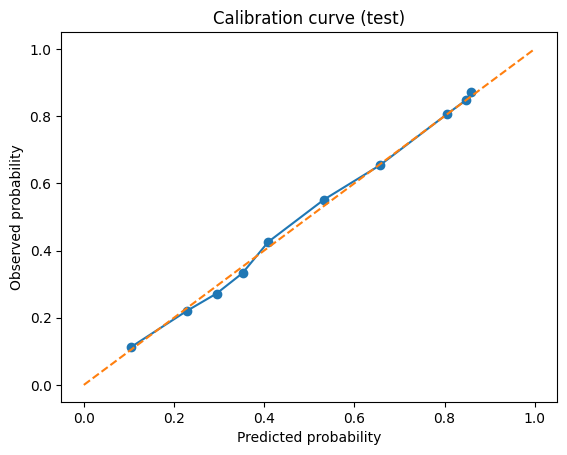

In [15]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, p_test, n_bins=10, strategy="quantile")

plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed probability")
plt.title("Calibration curve (test)")
plt.show()


## Explainability (SHAP)

We compute SHAP on a small sample to show which features drive risk predictions.


/tmp/ipython-input-3437593933.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, sample, show=False)


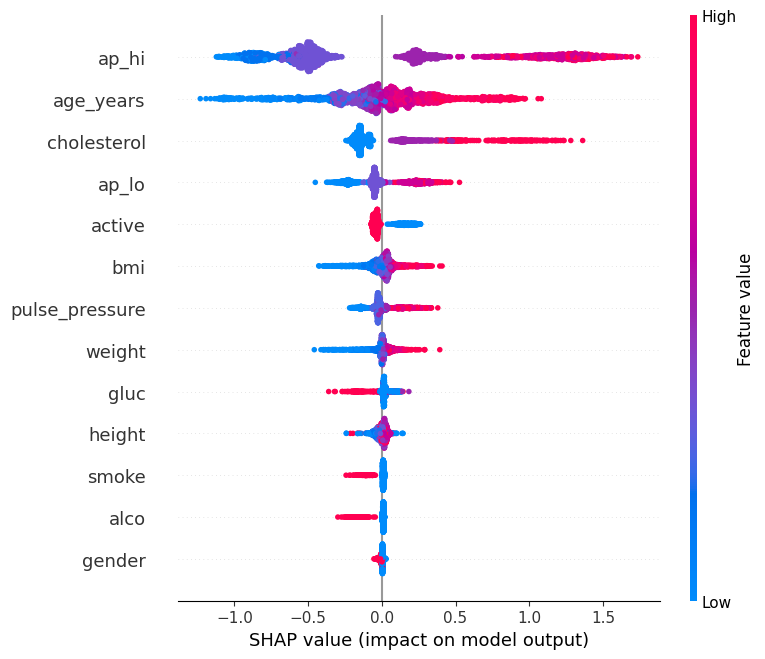

In [16]:
import shap
import matplotlib.pyplot as plt

sample = X_test.sample(n=min(2000, len(X_test)), random_state=SEED)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(sample)

shap.summary_plot(shap_values, sample, show=False)
plt.tight_layout()
plt.show()


## Build recommendation labels (diet, activity, sleep, stress)

The Kaggle dataset does not contain recommendation labels.
We create labels with transparent IF-THEN rules.
Then we train a multi-label model.


In [17]:
import copy
import numpy as np
import pandas as pd

# 1) One detailed card per label (used at inference). No per-row text duplication.
REC_LIBRARY = {
    "diet_low_sodium": {
        "title": "Reduce sodium to improve blood pressure control",
        "priority": "high",
        "why_it_matters": [
            "Blood pressure is elevated (ap_hi={ap_hi:.0f}, ap_lo={ap_lo:.0f}).",
            "Lower sodium intake can support better BP control over time."
        ],
        "what_to_do": [
            "Reduce processed foods and salty snacks.",
            "Avoid adding salt at the table. Taste first.",
            "Use herbs, lemon, garlic, and spices for flavor."
        ],
        "targets": [
            "Make 1 low-sodium meal choice per day for 14 days.",
            "Track BP changes to find what improves your readings."
        ],
        "follow_up": "If home BP stays high for 1–2 weeks, discuss the trend with a clinician."
    },
    "bp_home_monitoring": {
        "title": "Start structured home blood pressure monitoring",
        "priority": "high",
        "why_it_matters": [
            "Single readings vary. Trends give better insight.",
            "Home monitoring helps confirm whether changes are working."
        ],
        "what_to_do": [
            "Measure BP twice daily for 7 days (morning and evening).",
            "Rest 5 minutes before measuring. Use the same arm and cuff placement.",
            "Log date/time, sleep quality, stress, caffeine, and symptoms."
        ],
        "targets": ["Create a 7-day baseline, then re-check weekly."],
        "follow_up": "Share your BP log during follow-up visits."
    },
    "diet_mediterranean": {
        "title": "Shift toward a heart-healthy eating pattern",
        "priority": "medium",
        "why_it_matters": [
            "Cholesterol category is elevated (cholesterol={cholesterol}).",
            "Higher fiber and healthier fats support lipid control."
        ],
        "what_to_do": [
            "Increase vegetables, legumes, whole grains, and nuts.",
            "Prefer fish and lean proteins over processed meats.",
            "Swap fried foods for grilled, baked, or steamed options."
        ],
        "targets": [
            "Add 1 high-fiber meal per day for 14 days.",
            "Replace 2 processed snacks per week with nuts or fruit."
        ],
        "follow_up": "Consider repeating a lipid test after sustained changes."
    },
    "lipid_followup": {
        "title": "Arrange lipid follow-up and review results",
        "priority": "medium",
        "why_it_matters": [
            "Lipid trends help confirm whether diet and activity changes are working."
        ],
        "what_to_do": [
            "Schedule a lipid panel when appropriate for your care plan.",
            "Bring recent results to your clinician review."
        ],
        "targets": ["Keep a record of results and dates to track progress."],
        "follow_up": "Discuss targets and next steps based on your history and risk."
    },
    "diet_reduce_added_sugar": {
        "title": "Reduce added sugar and improve carbohydrate quality",
        "priority": "medium",
        "why_it_matters": [
            "Glucose category is elevated (gluc={gluc}).",
            "Reducing spikes supports metabolic control and weight management."
        ],
        "what_to_do": [
            "Avoid sugary drinks and limit desserts to planned occasions.",
            "Choose whole grains and pair carbs with protein/fiber.",
            "Avoid large late-night meals and sweet snacks before sleep."
        ],
        "targets": [
            "Replace sugary drinks with water or unsweetened options.",
            "Limit sweets to 1–2 planned servings per week."
        ],
        "follow_up": "Ask about fasting glucose or HbA1c testing if needed."
    },
    "glucose_followup": {
        "title": "Arrange glucose follow-up and review results",
        "priority": "medium",
        "why_it_matters": [
            "Glucose trends help confirm whether nutrition and activity changes are effective."
        ],
        "what_to_do": [
            "Discuss fasting glucose and/or HbA1c testing with your clinician.",
            "Track results over time rather than focusing on a single value."
        ],
        "targets": ["Record test dates and results to monitor trend."],
        "follow_up": "Discuss targets and next steps based on your risk profile."
    },
    "activity_aerobic": {
        "title": "Increase weekly aerobic activity safely",
        "priority": "medium",
        "why_it_matters": [
            "Low activity or excess weight can increase cardiovascular risk (active={active}, BMI={bmi:.1f}).",
            "Aerobic activity supports BP, glucose, and lipid control."
        ],
        "what_to_do": [
            "Start brisk walking 20–30 minutes, 3 days per week.",
            "Add 1 day per week until most days.",
            "Increase gradually with warm-up and cool-down."
        ],
        "targets": ["Progress steadily over 4 weeks."],
        "follow_up": "Stop if chest discomfort, unusual breathlessness, or dizziness occurs and seek medical advice."
    },
    "activity_strength": {
        "title": "Add strength training to support metabolic health",
        "priority": "low",
        "why_it_matters": [
            "Strength training supports glucose control and long-term weight maintenance."
        ],
        "what_to_do": [
            "Do 2 sessions per week (bodyweight squats, wall push-ups, resistance bands).",
            "Keep sessions short (15–20 minutes) and focus on consistency."
        ],
        "targets": ["2 sessions per week for 4 weeks."],
        "follow_up": "Increase intensity only after consistency improves."
    },
    "weight_loss_plan": {
        "title": "Start a structured weight-loss plan",
        "priority": "medium",
        "why_it_matters": [
            "BMI is elevated (BMI={bmi:.1f}).",
            "Modest weight reduction can improve BP and metabolic markers."
        ],
        "what_to_do": [
            "Track weight weekly and track 1 daily habit (example: sugary drinks).",
            "Plan meals to reduce unplanned snacking.",
            "Prioritize protein and vegetables for better satiety."
        ],
        "targets": ["Aim for gradual progress over 4 weeks."],
        "follow_up": "If no change after 4 weeks, adjust 1 habit at a time."
    },
    "sleep_hygiene": {
        "title": "Improve sleep habits",
        "priority": "low",
        "why_it_matters": [
            "Poor sleep can worsen BP control and appetite regulation."
        ],
        "what_to_do": [
            "Keep a fixed sleep/wake time on most days.",
            "Stop screens 30–60 minutes before bed.",
            "Avoid caffeine late in the day and heavy meals close to bedtime.",
            "Keep the room dark, cool, and quiet."
        ],
        "targets": ["Track sleep duration and wake time for 7 days."],
        "follow_up": "If loud snoring or daytime sleepiness is frequent, discuss sleep screening."
    },
    "stress_reduction": {
        "title": "Use a short daily stress routine",
        "priority": "low",
        "why_it_matters": [
            "Stress can raise heart rate and BP and make habits harder to maintain."
        ],
        "what_to_do": [
            "Slow breathing twice daily for 5 minutes (inhale 4 seconds, exhale 6 seconds).",
            "Add 1 planned break daily (short walk, stretching, quiet time).",
            "Reduce triggers such as late caffeine, skipped meals, and sleep debt."
        ],
        "targets": ["2 short routines per day for 14 days."],
        "follow_up": "If symptoms persist, consider structured support with a clinician."
    },
    "smoking_cessation": {
        "title": "Create a quit plan with a clear start date",
        "priority": "high",
        "why_it_matters": [
            "Smoking is a major modifiable cardiovascular risk factor."
        ],
        "what_to_do": [
            "Set a quit date within 14 days.",
            "List your top triggers and prepare replacements (gum, walk, water).",
            "Consider nicotine replacement or clinician support if needed."
        ],
        "targets": ["Reduce daily smoking until quit date, then stop completely."],
        "follow_up": "Support options can improve quit success rates."
    },
    "alcohol_reduction": {
        "title": "Reduce alcohol intake to support BP and sleep",
        "priority": "low",
        "why_it_matters": [
            "Alcohol can raise BP and reduce sleep quality."
        ],
        "what_to_do": [
            "Set a weekly limit and track drinks per day.",
            "Plan alcohol-free days and increase them gradually.",
            "Avoid alcohol close to bedtime."
        ],
        "targets": ["Reduce drinking days first, then reduce drinks per day."],
        "follow_up": "If reducing is difficult, start with alcohol-free days."
    },
    "clinician_followup_urgent": {
        "title": "Seek urgent clinical review for very high blood pressure",
        "priority": "high",
        "why_it_matters": [
            "BP is extremely high (ap_hi={ap_hi:.0f}, ap_lo={ap_lo:.0f}).",
            "Very high BP needs prompt evaluation."
        ],
        "what_to_do": [
            "Re-check BP after 5–10 minutes of rest to confirm.",
            "If still very high or you feel unwell, seek urgent care."
        ],
        "targets": [],
        "follow_up": "Do not delay if chest pain, severe headache, weakness, or shortness of breath occurs."
    },
    "clinician_followup_routine": {
        "title": "Book a routine clinician review",
        "priority": "medium",
        "why_it_matters": [
            "Follow-up helps turn risk signals into a clear plan."
        ],
        "what_to_do": [
            "Bring BP logs and recent lab results if available.",
            "Discuss targets for BP, cholesterol, glucose, and lifestyle."
        ],
        "targets": [],
        "follow_up": "Regular review supports steady risk reduction."
    }
}

REC_LABELS = list(REC_LIBRARY.keys())

def _sf(x, default=0.0):
    try:
        if pd.isna(x):
            return default
        return float(x)
    except Exception:
        return default

def _si(x, default=0):
    try:
        if pd.isna(x):
            return default
        return int(float(x))
    except Exception:
        return default

def make_labels(row: pd.Series) -> dict:
    labels = {k: 0 for k in REC_LABELS}

    ap_hi = _sf(row.get("ap_hi"))
    ap_lo = _sf(row.get("ap_lo"))
    bmi = _sf(row.get("bmi"))
    chol = _si(row.get("cholesterol"), 1)
    gluc = _si(row.get("gluc"), 1)
    smoke = _si(row.get("smoke"))
    alco = _si(row.get("alco"))
    active = _si(row.get("active"))
    age = _sf(row.get("age_years"))

    bp_stage2 = (ap_hi >= 140) or (ap_lo >= 90)
    bp_stage3 = (ap_hi >= 180) or (ap_lo >= 120)
    bp_very_high = (ap_hi >= 160) or (ap_lo >= 100)

    overweight = bmi >= 25
    obese = bmi >= 30

    dyslipidemia = chol >= 2
    hyperglycemia = gluc >= 2

    inactive = active == 0
    rf_count = int(bp_stage2) + int(obese) + int(dyslipidemia) + int(hyperglycemia) + int(smoke == 1)

    # BP labels
    if bp_stage2:
        labels["diet_low_sodium"] = 1
        labels["bp_home_monitoring"] = 1

    # Diet labels
    if dyslipidemia:
        labels["diet_mediterranean"] = 1
        labels["lipid_followup"] = 1

    if hyperglycemia:
        labels["diet_reduce_added_sugar"] = 1
        labels["glucose_followup"] = 1

    # Activity / weight labels
    if inactive or overweight:
        labels["activity_aerobic"] = 1

    if obese:
        labels["weight_loss_plan"] = 1
        labels["activity_strength"] = 1

    # Sleep / stress labels
    if bp_stage2 or hyperglycemia or smoke == 1 or inactive:
        labels["sleep_hygiene"] = 1
        labels["stress_reduction"] = 1

    # Smoking / alcohol
    if smoke == 1:
        labels["smoking_cessation"] = 1
    if alco == 1:
        labels["alcohol_reduction"] = 1

    # Follow-up labels
    if bp_stage3:
        labels["clinician_followup_urgent"] = 1
    elif bp_very_high or (age >= 55 and rf_count >= 2):
        labels["clinician_followup_routine"] = 1

    return labels

# Build label_df (training targets)
label_df = pd.DataFrame([make_labels(r) for _, r in df.iterrows()])[REC_LABELS]


## Train a multi-label recommendation model

We use One-vs-Rest Logistic Regression.
Then we train a small bootstrap ensemble to get a confidence score.


In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# Features + multi-label targets
X_rec = X.copy()
Y_rec = label_df.copy()

# Identify numeric vs categorical columns (safe for mixed schemas)
num_cols = X_rec.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_rec.columns if c not in num_cols]

# Split (keep stratify on original cardio label to preserve risk distribution)
Xr_train, Xr_test, Yr_train, Yr_test = train_test_split(
    X_rec, Y_rec, test_size=0.20, random_state=SEED, stratify=y
)

# Preprocessing: scale numeric, one-hot encode categoricals (ignore unseen categories at test)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

# Multi-label classifier
base_clf = OneVsRestClassifier(
    LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        solver="liblinear"  # stable for OVR on sparse outputs
    ),
    n_jobs=-1
)

pipe_rec = Pipeline([
    ("prep", preprocess),
    ("clf", base_clf),
])

pipe_rec.fit(Xr_train, Yr_train)

# Predict probabilities for each label
proba = pipe_rec.predict_proba(Xr_test)

# Per-label metrics (skip labels that are all 0 or all 1 in the test split)
label_auc = {}
label_ap = {}

for j, col in enumerate(Y_rec.columns):
    y_true = Yr_test[col].values
    if np.unique(y_true).size < 2:
        continue
    y_score = proba[:, j]
    label_auc[col] = roc_auc_score(y_true, y_score)
    label_ap[col] = average_precision_score(y_true, y_score)

print("Labels evaluated:", len(label_auc), "/", Y_rec.shape[1])
print("Mean ROC-AUC:", float(np.mean(list(label_auc.values()))) if label_auc else None)
print("Mean PR-AUC :", float(np.mean(list(label_ap.values()))) if label_ap else None)

# Show strongest / weakest labels
if label_auc:
    top = sorted(label_auc.items(), key=lambda x: x[1], reverse=True)[:5]
    bottom = sorted(label_auc.items(), key=lambda x: x[1])[:5]
    print("\nTop 5 labels by ROC-AUC:")
    for k, v in top:
        print(f"  {k:28s} {v:.3f}")
    print("\nBottom 5 labels by ROC-AUC:")
    for k, v in bottom:
        print(f"  {k:28s} {v:.3f}")


Labels evaluated: 15 / 15
Mean ROC-AUC: 0.9951791396540289
Mean PR-AUC : 0.9795868948775189

Top 5 labels by ROC-AUC:
  diet_mediterranean           1.000
  lipid_followup               1.000
  diet_reduce_added_sugar      1.000
  glucose_followup             1.000
  smoking_cessation            1.000

Bottom 5 labels by ROC-AUC:
  clinician_followup_routine   0.943
  diet_low_sodium              0.995
  bp_home_monitoring           0.995
  sleep_hygiene                0.998
  stress_reduction             0.998


In [19]:
import numpy as np
from sklearn.base import clone

# Bootstrap ensemble for uncertainty / confidence scoring
# Each model is trained on a bootstrapped sample of the training set.
N_BOOT = 7
rng = np.random.default_rng(SEED)

boot_models = []
n_train = len(Xr_train)

for b in range(N_BOOT):
    # Sample indices with replacement
    idx = rng.integers(low=0, high=n_train, size=n_train)

    # Use iloc to preserve alignment and avoid index issues
    Xb = Xr_train.iloc[idx].copy()
    Yb = Yr_train.iloc[idx].copy()

    model_b = clone(pipe_rec)
    model_b.fit(Xb, Yb)
    boot_models.append(model_b)

print(f"Trained {len(boot_models)} bootstrap models (N_BOOT={N_BOOT})")


Trained 7 bootstrap models (N_BOOT=7)


## Rank recommendations using counterfactual risk reduction

For each recommendation, we simulate a small change in risk factors.
Then we recompute the calibrated risk score.
This gives an estimated risk drop for ranking.


In [ ]:
INTERVENTIONS = {
    "diet_low_sodium": {"ap_hi": -5, "ap_lo": -3},
    "diet_mediterranean": {"cholesterol": -1},
    "activity_increase": {"ap_hi": -3, "ap_lo": -2, "weight_pct": -0.02},
    "weight_loss_plan": {"weight_pct": -0.05},
    "sleep_hygiene": {"ap_hi": -2, "ap_lo": -1},
    "stress_reduction": {"ap_hi": -4, "ap_lo": -2},
    "smoking_cessation": {"smoke": 0},
    "alcohol_reduction": {"alco": 0},
    "clinician_followup": {},
}

def apply_intervention(x_row: pd.Series, name: str) -> pd.Series:
    x2 = x_row.copy()
    eff = INTERVENTIONS.get(name, {})

    for k, v in eff.items():
        if k == "weight_pct":
            continue
        if k in ["cholesterol", "gluc"]:
            x2[k] = int(max(1, min(3, int(x2[k] + v))))
        elif k in ["ap_hi", "ap_lo"]:
            x2[k] = float(x2[k] + v)
        elif k in ["smoke", "alco", "active"]:
            x2[k] = int(v)
        else:
            x2[k] = x2.get(k, v)

    if "weight_pct" in eff:
        x2["weight"] = float(x2["weight"] * (1.0 + eff["weight_pct"]))

    x2["bmi"] = float(x2["weight"] / (x2["height"] / 100.0) ** 2)
    x2["pulse_pressure"] = float(x2["ap_hi"] - x2["ap_lo"])
    return x2

def risk_score(x_row: pd.Series) -> float:
    return float(cal.predict_proba(pd.DataFrame([x_row]))[:, 1][0])

def estimate_risk_drop(x_row: pd.Series, rec_name: str) -> float:
    base = risk_score(x_row)
    x2 = apply_intervention(x_row, rec_name)
    new = risk_score(x2)
    return max(0.0, base - new)

print("Ready")


## Inference: ranked, explainable recommendations




In [20]:
import numpy as np
import pandas as pd

INTERVENTION_EFFECTS = {
    "diet_low_sodium": {"ap_hi": -5.0, "ap_lo": -3.0},
    "diet_mediterranean": {"cholesterol": -1},
    "diet_reduce_added_sugar": {"gluc": -1},
    "activity_aerobic": {"ap_hi": -3.0, "ap_lo": -2.0, "weight_pct": -0.02, "active": 1},
    "activity_strength": {"weight_pct": -0.01, "active": 1},
    "weight_loss_plan": {"weight_pct": -0.05},
    "sleep_hygiene": {"ap_hi": -2.0, "ap_lo": -1.0},
    "stress_reduction": {"ap_hi": -4.0, "ap_lo": -2.0},
    "smoking_cessation": {"smoke": 0},
    "alcohol_reduction": {"alco": 0},
    "clinician_followup_routine": {},
    "clinician_followup_urgent": {},
    "bp_home_monitoring": {},
    "lipid_followup": {},
    "glucose_followup": {},
}

def _clip_ordinal_1_3(x):
    return int(np.clip(int(round(float(x))), 1, 3))

def apply_intervention(x_row: pd.Series, label: str) -> pd.Series:
    x2 = x_row.copy()
    eff = INTERVENTION_EFFECTS.get(label, {})

    # Apply direct feature shifts
    for feat, delta in eff.items():
        if feat == "weight_pct":
            continue

        if feat in ("cholesterol", "gluc"):
            x2[feat] = _clip_ordinal_1_3(float(x2.get(feat, 1)) + float(delta))
        elif feat in ("ap_hi", "ap_lo"):
            x2[feat] = float(x2.get(feat, 0.0)) + float(delta)
        elif feat in ("smoke", "alco", "active"):
            x2[feat] = int(delta)
        else:
            if feat not in x2:
                x2[feat] = delta

    # Apply weight %
    if "weight_pct" in eff and "weight" in x2:
        x2["weight"] = float(x2["weight"]) * (1.0 + float(eff["weight_pct"]))

    # Recompute derived features only if inputs exist
    if ("weight" in x2) and ("height" in x2) and float(x2["height"]) > 0:
        h_m = float(x2["height"]) / 100.0
        x2["bmi"] = float(x2["weight"]) / (h_m ** 2)

    if ("ap_hi" in x2) and ("ap_lo" in x2):
        x2["pulse_pressure"] = float(x2["ap_hi"]) - float(x2["ap_lo"])

    return x2

def risk_score(x_row: pd.Series, risk_model, features: list) -> float:
    X1 = pd.DataFrame([{c: x_row.get(c, 0) for c in features}], columns=features)
    return float(risk_model.predict_proba(X1)[:, 1][0])

def estimate_risk_drop(x_row: pd.Series, label: str, risk_model, features: list) -> float:
    base = risk_score(x_row, risk_model, features)
    x2 = apply_intervention(x_row, label)
    new = risk_score(x2, risk_model, features)
    return float(max(0.0, base - new))


## Save artifacts + zip for download



In [ ]:
import json
import joblib
from pathlib import Path
from datetime import datetime


# Output folders

OUT_DIR = Path("/content/cardiosense_component3")
MODELS_DIR = OUT_DIR / "models"
DATA_DIR = OUT_DIR / "data"
REPORTS_DIR = OUT_DIR / "reports"

for p in (OUT_DIR, MODELS_DIR, DATA_DIR, REPORTS_DIR):
    p.mkdir(parents=True, exist_ok=True)


# Save models

artifacts = {
    "risk_model_calibrated.joblib": cal,
    "risk_model_xgb_raw.joblib": xgb,
    "recommender_base.joblib": pipe_rec,
    "recommender_bootstrap.joblib": boot_models,
}

for name, obj in artifacts.items():
    joblib.dump(obj, MODELS_DIR / name)


# Save data outputs

df.to_csv(DATA_DIR / "cardio_cleaned.csv", index=False)
label_df.to_csv(DATA_DIR / "recommendation_labels.csv", index=False)


label_stats = (
    label_df.mean()
    .sort_values(ascending=False)
    .to_frame("prevalence")
    .reset_index()
    .rename(columns={"index": "label"})
)
label_stats.to_csv(REPORTS_DIR / "label_prevalence.csv", index=False)


meta = {
    "project": "CardioSense",
    "component": 3,
    "created_utc": datetime.utcnow().replace(microsecond=0).isoformat() + "Z",
    "dataset_handle": globals().get("DATASET_HANDLE", None),
    "seed": globals().get("SEED", None),
    "n_records": int(df.shape[0]),
    "n_features": int(X.shape[1]),
    "features": list(X.columns),
    "recommendation_labels": list(label_df.columns),
    "n_bootstrap_models": int(len(boot_models)) if "boot_models" in globals() else None,
}

(OUT_DIR / "meta.json").write_text(json.dumps(meta, indent=2))

print(f"Saved artifacts to: {OUT_DIR}")
print(f"- Models:  {MODELS_DIR}")
print(f"- Data:    {DATA_DIR}")
print(f"- Reports: {REPORTS_DIR}")


Saved artifacts to: /content/cardiosense_component3
- Models:  /content/cardiosense_component3/models
- Data:    /content/cardiosense_component3/data
- Reports: /content/cardiosense_component3/reports


/tmp/ipython-input-3675444708.py:52: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_utc": datetime.utcnow().replace(microsecond=0).isoformat() + "Z",


In [22]:
ZIP_PATH = "/content/CardioSense_Component3_Artifacts.zip"

!rm -f "$ZIP_PATH"
!zip -r "$ZIP_PATH" /content/cardiosense_component3 > /dev/null

from google.colab import files
files.download(ZIP_PATH)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# --- Sample output viewer (risk + recommendations) ---
import json
import numpy as np
import pandas as pd

def _add_derived_fields(u: dict) -> dict:
    u = dict(u)
    if "bmi" not in u and "weight" in u and "height" in u and float(u["height"]) > 0:
        h_m = float(u["height"]) / 100.0
        u["bmi"] = float(u["weight"]) / (h_m ** 2)
    if "pulse_pressure" not in u and "ap_hi" in u and "ap_lo" in u:
        u["pulse_pressure"] = float(u["ap_hi"]) - float(u["ap_lo"])
    return u

# Example patient (edit values)
sample_user = _add_derived_fields({
    "age_years": 55,
    "gender": 2,
    "height": 170,
    "weight": 86,
    "ap_hi": 155,
    "ap_lo": 95,
    "cholesterol": 3,
    "gluc": 2,
    "smoke": 1,
    "alco": 0,
    "active": 0,
})

# Generate output using your inference function
out = recommend_real_world(
    user_input=sample_user,
    cal=cal,
    pipe_rec=pipe_rec,
    boot_models=boot_models,
    features=FEATURES,
    threshold=0.50,
    top_k=6
)

print("Risk:", out["risk"])
print()

# Pretty print recommendation cards
recs_df = pd.DataFrame(out["recommendations"])
cols = [c for c in ["label","probability","confidence_band","title","priority"] if c in recs_df.columns]
display(recs_df[cols])

# Show detailed card text for the top recommendation
if out["recommendations"]:
    top = out["recommendations"][0]
    print("\nTop recommendation details")
    print("Title:", top.get("title", ""))
    print("Priority:", top.get("priority", ""))
    print("\nWhy it matters:")
    for x in top.get("why_it_matters", []):
        print("-", x)
    print("\nWhat to do:")
    for x in top.get("what_to_do", []):
        print("-", x)
    if top.get("targets"):
        print("\nTargets:")
        for x in top.get("targets", []):
            print("-", x)
    if top.get("follow_up"):
        print("\nFollow-up:", top.get("follow_up"))


Risk: {'risk_probability': 0.847953200340271, 'risk_band': 'high'}



,label,probability,confidence_band,title,priority
0,activity_aerobic,1.0,high,Increase weekly aerobic activity safely,medium
1,sleep_hygiene,1.0,high,Improve sleep habits,low
2,stress_reduction,1.0,high,Use a short daily stress routine,low
3,lipid_followup,1.0,high,Arrange lipid follow-up and review results,medium
4,diet_mediterranean,1.0,high,Shift toward a heart-healthy eating pattern,medium
5,bp_home_monitoring,1.0,high,Start structured home blood pressure monitoring,high



Top recommendation details
Title: Increase weekly aerobic activity safely
Priority: medium

Why it matters:
- Low activity or excess weight can increase cardiovascular risk (active=0.0, BMI=29.8).
- Aerobic activity supports BP, glucose, and lipid control.

What to do:
- Start brisk walking 20–30 minutes, 3 days per week.
- Add 1 day per week until most days.
- Increase gradually with warm-up and cool-down.

Targets:
- Progress steadily over 4 weeks.

Follow-up: Stop if chest discomfort, unusual breathlessness, or dizziness occurs and seek medical advice.
